In [121]:
import warnings
warnings.simplefilter(action='ignore')

In [122]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np

In [123]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [124]:
adata = sc.read('../dataset/tyser.h5ad')
hips = sc.read("../dataset/hiPSC.h5ad")

In [125]:
sca.utils.add_annotations(adata, '../metadata/reactome.gmt', min_genes=12, clean=True)

In [126]:
missing_genes = [gene for gene in adata.var_names if gene not in hips.var_names]
print(f"Aantal genen in hips die niet in tyser staan: {len(missing_genes)}")
print("Ontbrekende genen:", missing_genes)

Aantal genen in hips die niet in tyser staan: 36008
Ontbrekende genen: ['A1BG.AS1', 'A2M.AS1', 'A2ML1.AS1', 'A2ML1.AS2', 'A2MP1', 'A3GALT2', 'A4GNT', 'AA06', 'AACSP1', 'AADACL2', 'AADACL2.AS1', 'AADACL4', 'AADACP1', 'AARSP1', 'AB015752.1', 'ABBA01000935.1', 'ABBA01006766.1', 'ABCA10', 'ABCA11P', 'ABCA13', 'ABCA17P', 'ABCA6', 'ABCA9', 'ABCA9.AS1', 'ABCB10P1', 'ABCB10P3', 'ABCB10P4', 'ABCB5', 'ABCC13', 'ABCC5.AS1', 'ABCC6P1', 'ABCC6P2', 'ABCD1P2', 'ABCD1P3', 'ABCD1P4', 'ABCD1P5', 'ABCF2P1', 'ABCF2P2', 'ABHD11.AS1', 'ABHD14A.ACY1', 'ABHD15.AS1', 'ABHD16B', 'ABHD17AP1', 'ABHD17AP3', 'ABHD17AP4', 'ABHD17AP5', 'ABHD17AP6', 'ABHD17AP7', 'ABHD17AP8', 'ABHD17AP9', 'ABI1P1', 'ABRA', 'ABT1P1', 'AC000032.1', 'AC000035.1', 'AC000036.1', 'AC000041.1', 'AC000058.1', 'AC000061.1', 'AC000067.1', 'AC000077.1', 'AC000078.1', 'AC000081.1', 'AC000089.1', 'AC000095.1', 'AC000095.2', 'AC000111.1', 'AC000111.2', 'AC000120.1', 'AC000120.2', 'AC000120.3', 'AC000123.1', 'AC000123.2', 'AC000123.3', 'AC000124.1', 

In [127]:
commom = adata.var_names.intersection(hips.var_names)
hips = hips[:, commom].copy()
adata = adata[:, commom].copy()

In [128]:
adata.raw.X.toarray()[0]

array([2., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0.])

In [129]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [130]:
sc.pp.normalize_total(adata)

In [131]:
sc.pp.log1p(adata)

In [132]:
adata.obs['batch'] = 'reference'

In [133]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [134]:
select_terms = adata.varm['I'].sum(0) > 12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [135]:
adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)

In [136]:
adata.raw.X.toarray()[0]

array([2., 0., 0., 0., 0., 0., 0., ..., 0., 0., 0., 0., 0., 0., 0.])

In [137]:
adata.X.toarray()[0]

array([0.  , 0.  , 3.69, 1.48, 0.  , 0.  , 0.  , ..., 0.  , 1.48, 0.  ,
       0.99, 0.  , 0.  , 2.41])

In [166]:
adata.X.shape

(1069, 1971)

In [168]:
adata.raw.X.shape

(1069, 57490)

In [138]:
# Overlap bepalen tussen gen-namen in adata.raw.var en adata.var
overlap_mask = adata.raw.var['_index'].isin(adata.var['features'])

# Controleer of het masker overeenkomt met het aantal kolommen in adata.raw.X
print("Lengte van overlap_mask:", len(overlap_mask))
print("Aantal kolommen in adata.raw.X:", adata.raw.X.shape[1])

# Filter de matrix op basis van de overlappende genen
if len(overlap_mask) == adata.raw.X.shape[1]:
    # Omzetten naar dense matrix (indien nodig)
    raw_X_dense = adata.raw.X.toarray()
    
    # Filter de kolommvaren op basis van overlap_mask
    filtered_raw_X = raw_X_dense[:, overlap_mask.values]
    
    # Resultaat
    print("Gefilterde matrix shape:", filtered_raw_X.shape)
else:
    print("Dimensies komen niet overeen! Controleer adata.raw.var en adata.raw.X.")



# Stap 1: Zorg ervoor dat de gefilterde matrix in het float32 formaat is
filtered_raw_X_float32 = filtered_raw_X.astype(np.float32)

# Stap 2: Optioneel: Sla de matrix op als een numpy-bestand
np.save('filtered_raw_X_float32.npy', filtered_raw_X_float32)

# Stap 3: Kopieer de matrix naar adata.X
adata.X = filtered_raw_X_float32

# Controleer de dimensies en het datatype van adata.X
print("Vorm van adata.X:", adata.X.shape)
print("Datatype van adata.X:", adata.X.dtype)

Lengte van overlap_mask: 57490
Aantal kolommen in adata.raw.X: 57490
Gefilterde matrix shape: (1069, 1971)
Vorm van adata.X: (1069, 1971)
Datatype van adata.X: float32


In [139]:
#adata.X = adata.raw.X.copy()
#adata.X = adata.X.copy()

In [140]:
#missing_genes = [gene for gene in adata.var_names if gene not in hips.var_names]
#print(f"Aantal genen in hips die niet in tyser staan: {len(missing_genes)}")
#print("Ontbrekende genen:", missing_genes)

In [141]:
#commom = adata.var_names.intersection(hips.var_names)
#hips = hips[:, commom].copy()
#adata = adata[:, commom].copy()


In [142]:
adata

AnnData object with n_obs × n_vars = 1069 × 1971
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt', 'batch'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'terms', 'log1p', 'hvg'
    varm: 'I'

In [143]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='batch',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1971 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 233
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  233 0 0 1 1971
	with hard mask.
Last Decoder layer: softmax


In [144]:
ALPHA = 0.7

adata.X = adata.X.astype(np.float32)

In [145]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Preparing (1069, 1971)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |████████████████████| 100.0%  - epoch_loss: 3331.5135192871 - epoch_recon_loss: 3195.6412658691 - epoch_kl_loss: 271.7444801331 - val_loss: 3514.3620605469 - val_recon_loss: 3381.4670410156 - val_kl_loss: 265.790252685551
Saving best state of network...
Best State was in Epoch 398


In [146]:
MEAN = False

In [147]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [148]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [149]:
sc.tl.umap(adata)

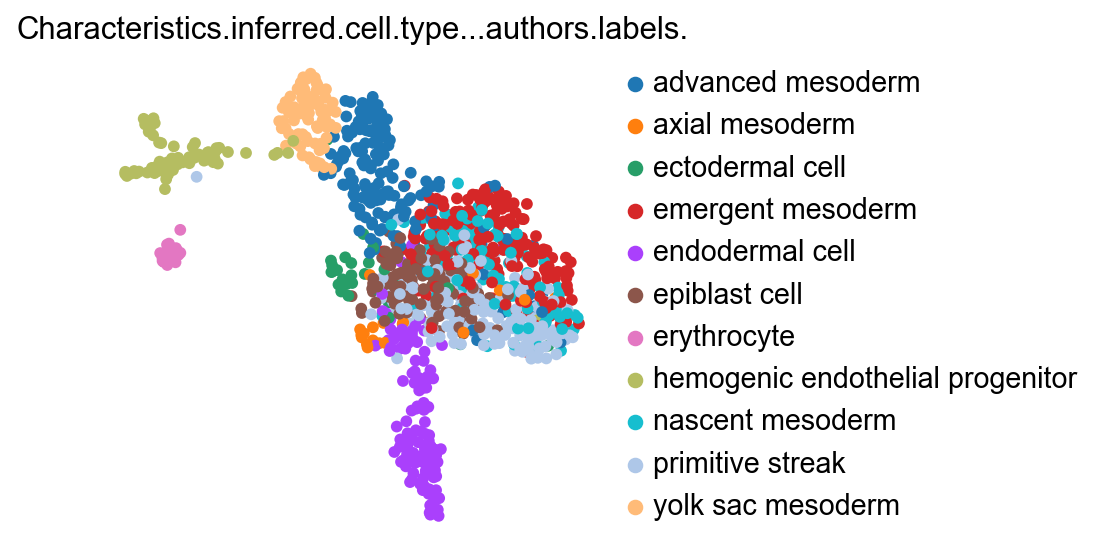

In [150]:
sc.pl.umap(adata, color=['Characteristics.inferred.cell.type...authors.labels.'], frameon=False)

In [151]:
hips.obs['batch'] = 'query'

In [152]:
hips.X = hips.X.astype(np.float32)


In [153]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(hips, intr_cvae)

Query data contains expression data of  19511  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 4694 × 1971
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'run', 'sample_name', 'percent.mt', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22', 'batch'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_mnn', 'X_umap'
    obsp: 'distances'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1971 256 2
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 233
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  233 0 0 2 1971
	with hard mask.
Last Decoder layer: softmax


In [154]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)


Preparing (4694, 1971)
Instantiating dataset
 |███████████---------| 56.8%  - val_loss: 1353.9902038574 - val_recon_loss: 1340.8171386719 - val_kl_loss: 131.7307662964
ADJUSTED LR
 |█████████████-------| 68.0%  - val_loss: 1354.4590759277 - val_recon_loss: 1341.3285217285 - val_kl_loss: 131.3054008484
ADJUSTED LR
 |██████████████------| 72.8%  - val_loss: 1355.7328186035 - val_recon_loss: 1342.6091003418 - val_kl_loss: 131.2370834351
ADJUSTED LR
 |██████████████------| 74.5%  - val_loss: 1353.3237915039 - val_recon_loss: 1340.1976318359 - val_kl_loss: 131.2615203857
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 276


In [155]:
#q_intr_cvae.save('hippietippe_model')

In [156]:
dataset_samen = sc.AnnData.concatenate(adata, hips, batch_key='batch_join', uns_merge='same')
dataset_samen


AnnData object with n_obs × n_vars = 5763 × 1971
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt', 'batch', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22', 'batch_join'
    var: 'features', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    obsm: 'X_umap'

In [157]:
dataset_samen.X = dataset_samen.X.astype(np.float32)


In [158]:
dataset_samen.obsm['X_cvae'] = q_intr_cvae.get_latent(dataset_samen.X, dataset_samen.obs['batch'], mean=MEAN, only_active=True)

In [159]:
sc.pp.neighbors(dataset_samen, use_rep='X_cvae')

In [160]:
sc.tl.umap(dataset_samen)


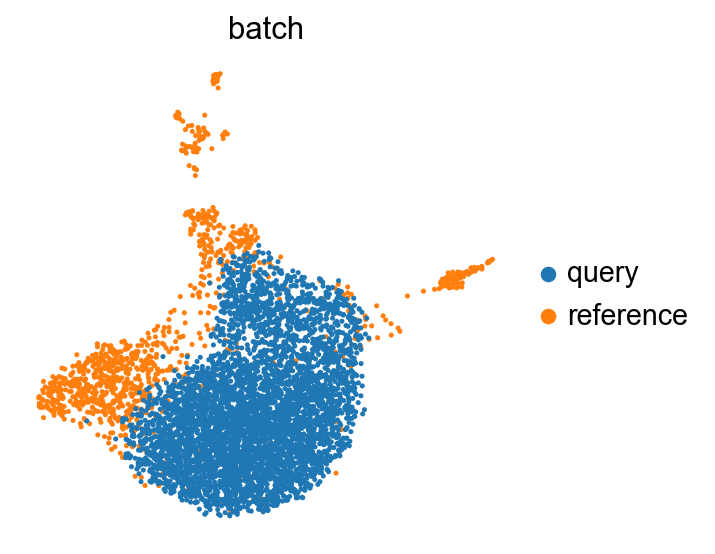

In [161]:
sc.pl.umap(dataset_samen, color=['batch'], frameon=False, wspace=0.6)


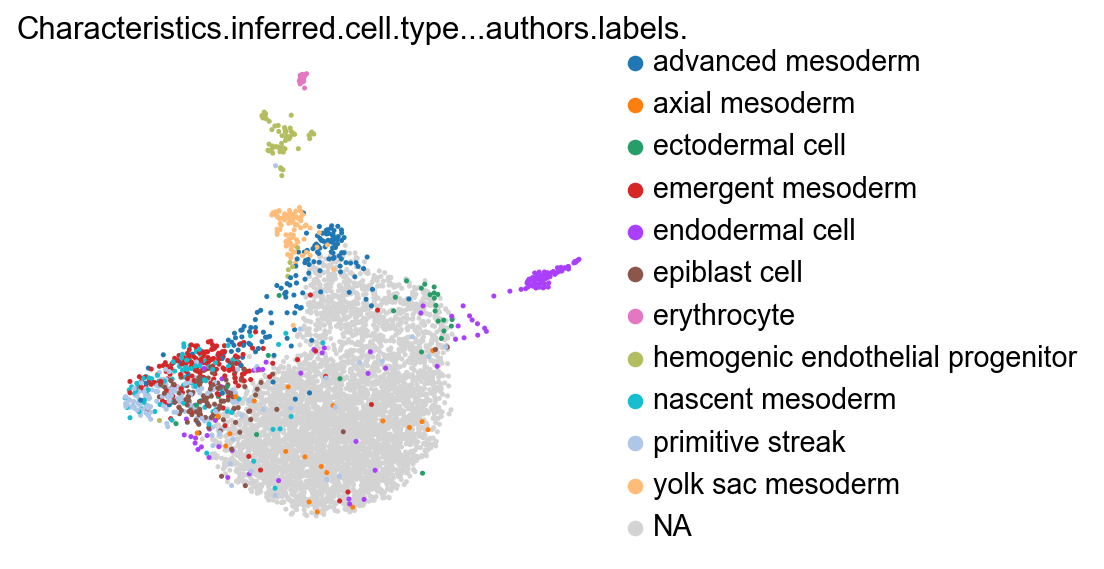

In [162]:
sc.pl.umap(dataset_samen, color=['Characteristics.inferred.cell.type...authors.labels.'], frameon=False, wspace=0.6)

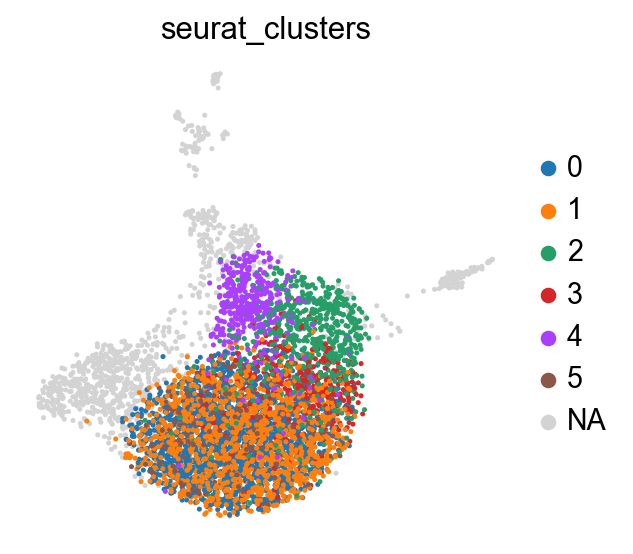

In [163]:

sc.pl.umap(dataset_samen, color=['seurat_clusters'], frameon=False, wspace=0.6)

In [164]:
dataset_samen.obs['orig.ident'] = dataset_samen.obs['orig.ident'].astype(str)


dataset_samen.write('hipstyser_integrated.h5ad')